In [1]:
!pip install git+https://github.com/UN-GCPDS/python-gcpds.utils.git > /dev/null

  Running command git clone -q https://github.com/UN-GCPDS/python-gcpds.utils.git /tmp/pip-req-build-zi95ryeu


In [2]:
!pip install mne==0.19 > /dev/null

In [ ]:
import sys
sys.path.insert(0,'/kaggle/input/mi-eeg-classmeth/')

In [6]:
from gcpds.utils import loaddb
import sys
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import numpy as np
from joblib import dump, load
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split,GridSearchCV, StratifiedShuffleSplit,LeaveOneOut
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score, pairwise_distances
from mne.viz import plot_topomap
from MIfunctions import * #importar todas las funciones de manejo de eeg con mne.
import os
from time import time
from CKA_keras import Keras_CKA 
from sklearn.metrics import make_scorer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import pickle

The subject 1 has 5 runs
(200, 64, 1792)
(200,)
680.2423322200775
sbj1acc73.0
The subject 2 has 5 runs
(200, 64, 1792)
(200,)
619.4887433052063
sbj2acc52.5
The subject 3 has 5 runs
(200, 64, 1792)
(200,)
669.5325798988342
sbj3acc89.5
The subject 4 has 5 runs
(200, 64, 1792)
(200,)
671.1882634162903
sbj4acc79.0
The subject 5 has 5 runs
(199, 64, 1792)
(199,)
696.0968732833862
sbj5acc79.5


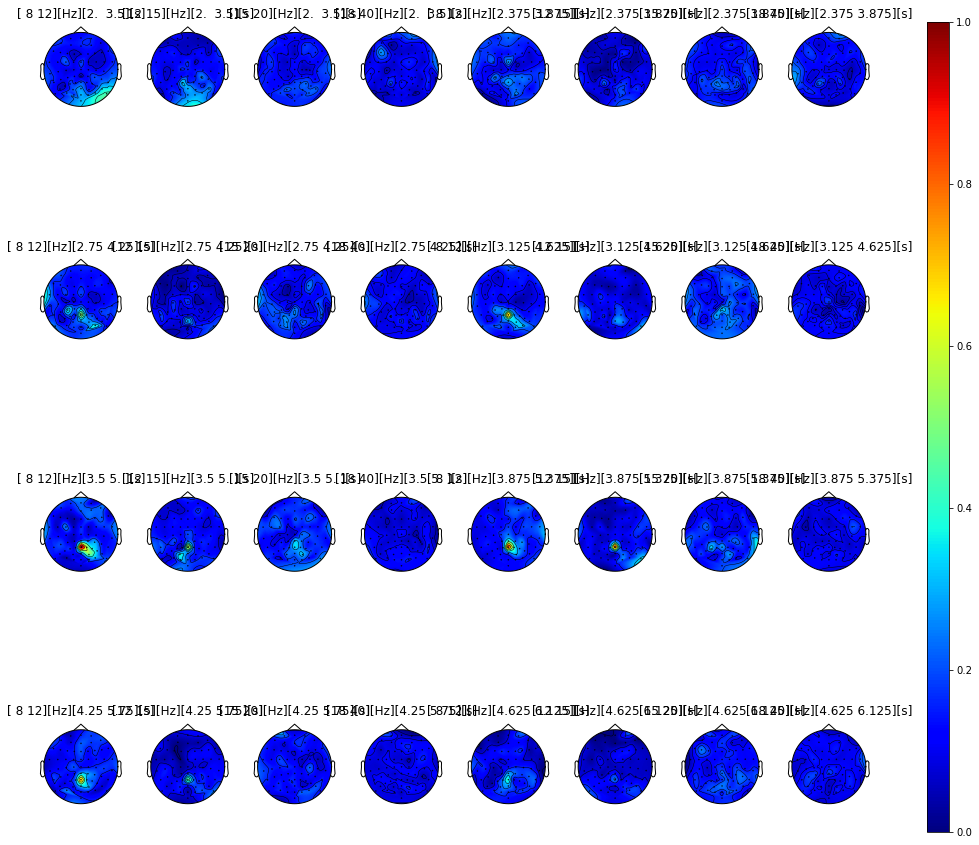

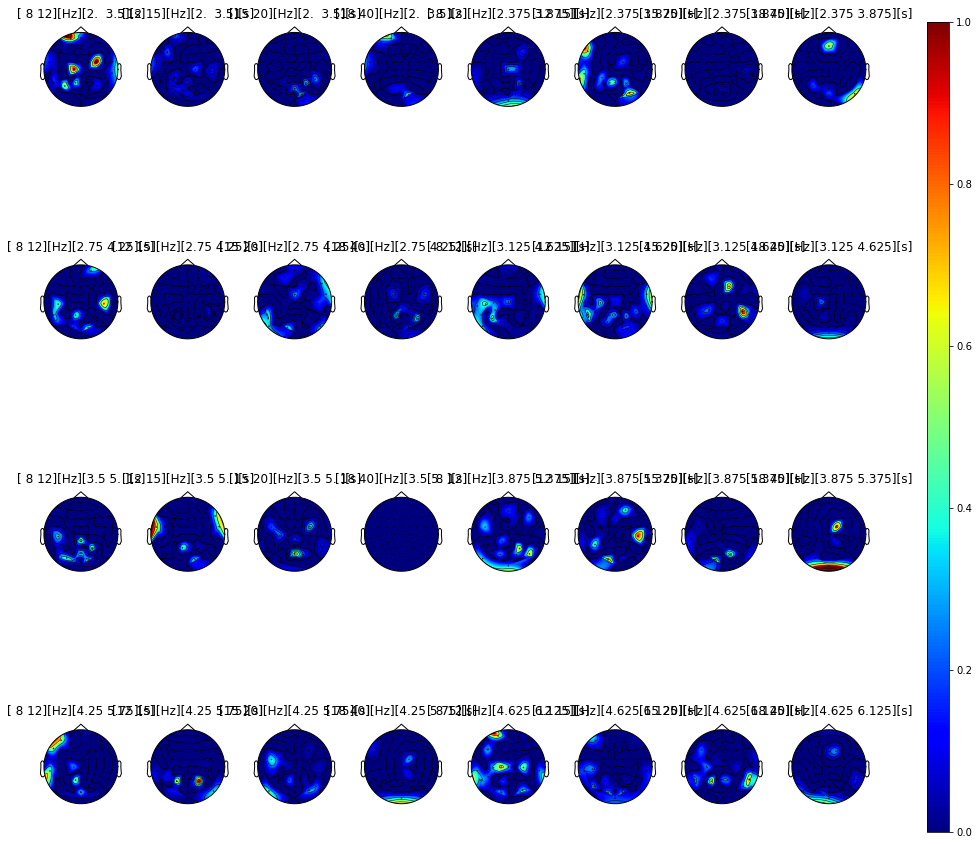

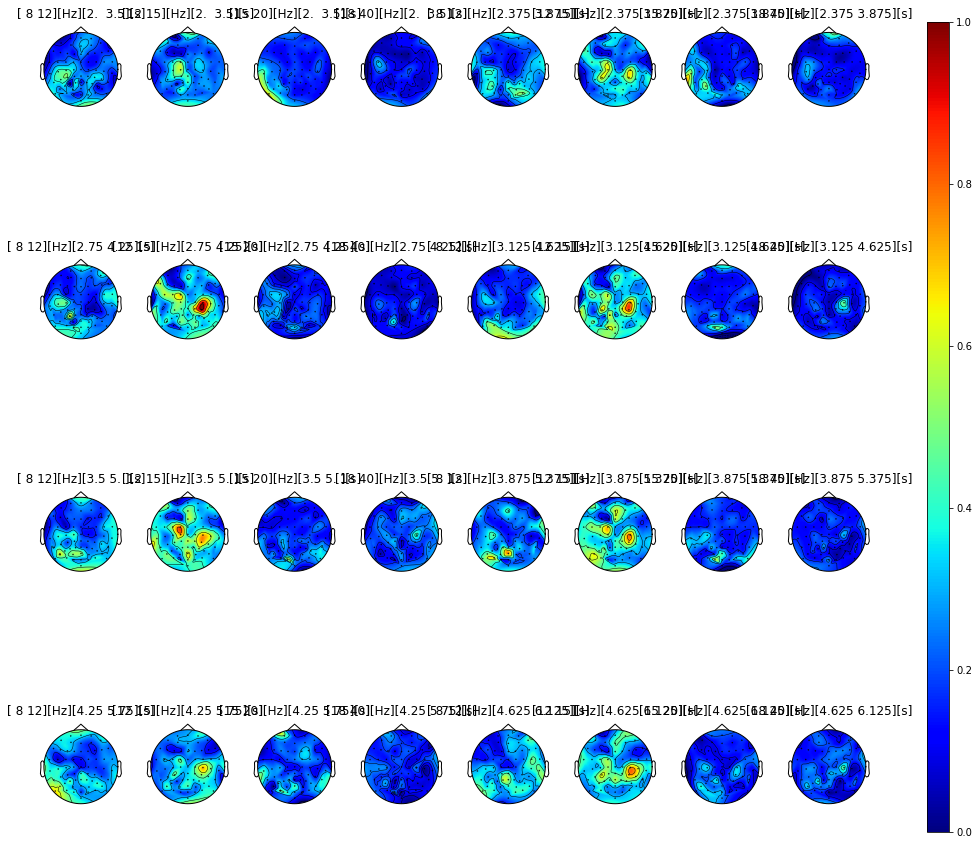

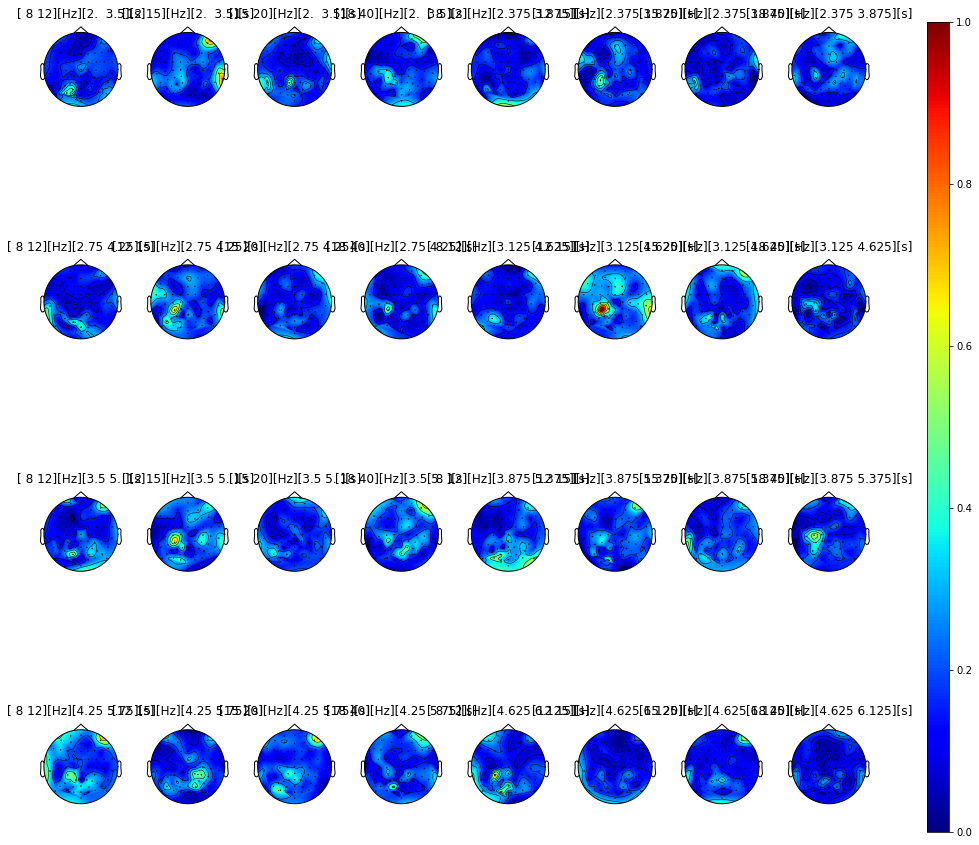

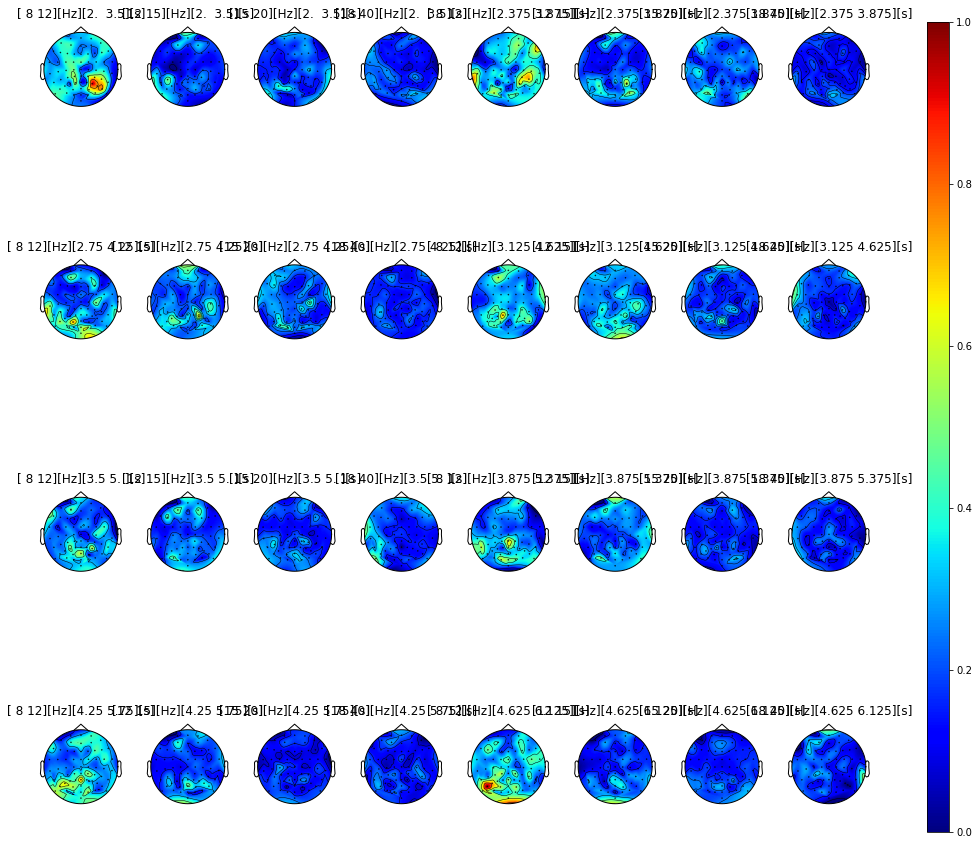

In [7]:
f_frec =  np.array([[8,12],[12,15],[15,20],[18,40]])
#vtw= np.array([[0,2],[1,3],[2,4],[3,5],[4,6],[5,7]])
tau =  1.5
overlap=1-0.75
ti = 2
tf = 6
tti = np.arange(ti,tf-tau+(tau*overlap),tau*overlap)
ttf = np.arange(ti+tau,tf+tau*overlap,tau*overlap)
vtw = np.array([tti,ttf]).T
#vtw= np.array([[0,2]])
#f_frec = np.array([[2.5,4.5]])
subjects = np.arange(52)+1
subjects=np.delete(subjects,[28,33])
for sbj in subjects[:5]:#subjects:
    db = loaddb.GIGA('../input/giga-science-gcpds/GIGA_MI_ME/')
    db.load_subject(sbj)
    print(f'The subject {sbj} has {db.runs} runs')
    Xraw, y = db.get_data(reject_bad_trials=True,classes=['left hand mi', 'right hand mi'])
    #run[i], class_[i] = db.get_run(i,classes=['left hand', 'right hand'])
    Xraw = np.asarray(Xraw)
    Xraw=Xraw[:,:,::2]
    print(Xraw.shape)
    y = np.asarray(y,dtype=np.float64).ravel()
    y[y==0]=-1
    print(y.shape)
    fs =db.metadata['sampling_rate']/2
    #fs =db.metadata['sampling_rate']
    channels_names = db.metadata['channel_names']
    montage = mne.channels.read_montage(db.metadata['montage'], channels_names)
    info = mne.create_info(channels_names, sfreq=fs, ch_types="eeg",
                            montage=montage) 
    feat = FB_feats(fs=fs,vtw=vtw,f_frec=f_frec,gammad=1,feat='PLV')
    #t=time()
    xxx = feat.fit_transform(Xraw,y) 
    #print(time()-t)
    #opt = tf.keras.optimizers.RMSprop(learning_rate=1e-1)
    #%%%%%% 
    steps=[('proy',elastic_net_feats()),
           ('cla', LDA())]
    method = Pipeline(steps,memory='/kaggle/tmp/datospipeline')
    parameters ={'proy__alpha':[0, 0.0001, 0.001, 0.1], #0, 0.001, 0.1
                'proy__l1_ratio':[0, 0.5, 1]} #[0, 0.5, 1]
    scores = {'acc': 'accuracy','kappa': make_scorer(cohen_kappa_score,greater_is_better=True)}    
    cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
    grid_search = GridSearchCV(method, parameters,cv=cv,verbose=0,
                               scoring=scores,refit='acc',n_jobs=-1)
    #grid_search = GridSearchCV(method, parameters,cv=cv,verbose=10,
     #                          scoring=kappa_,n_jobs=-1)
    #try:
    t=time()
    grid_search.fit(xxx,y)
    print(time()-t)
    results = grid_search.cv_results_
    #%% topoplots
    elastic=grid_search.best_estimator_['proy']
    rho = abs(elastic.elatic.coef_).mean(0)
    savedata ={
        'steps':steps,
        'best_param':grid_search.best_params_,
        'rho':rho,        
        'cv_results':results
    }
    #print(time()-t)
    #dump(savedata,'sujeto_'+str(sbj)+'_cka_featuresCSP_BCI2a_acc.joblib')
    dump(savedata,'sujeto_'+str(sbj)+'_elastic_featurespearson_GIGA_MI_acc.joblib')
    feat.rho_plot(rho,info,figsize=(15,15),save=True,sbj=sbj,acc=np.round(grid_search.best_score_*100,2),format='eps',Ch=len(channels_names))
    print('sbj'+str(sbj)+'acc'+str(np.round(grid_search.best_score_*100,4)))
    #print(time()-t)

In [8]:
!zip Results-joblib.zip ./*.joblib
!zip Results-images.zip ./*.eps

  adding: sujeto_1_elastic_featurespearson_GIGA_MI_acc.joblib (deflated 6%)
  adding: sujeto_2_elastic_featurespearson_GIGA_MI_acc.joblib (deflated 99%)
  adding: sujeto_3_elastic_featurespearson_GIGA_MI_acc.joblib (deflated 6%)
  adding: sujeto_4_elastic_featurespearson_GIGA_MI_acc.joblib (deflated 6%)
  adding: sujeto_5_elastic_featurespearson_GIGA_MI_acc.joblib (deflated 6%)
  adding: sbj1acc73.0.eps (deflated 82%)
  adding: sbj2acc52.5.eps (deflated 83%)
  adding: sbj3acc89.5.eps (deflated 79%)
  adding: sbj4acc79.0.eps (deflated 80%)
  adding: sbj5acc79.5.eps (deflated 80%)
